In [ ]:
from IPython.display import clear_output

!pip install --upgrade setuptools pip --user
!pip install onnx 
!pip install onnxruntime
#!pip install --ignore-installed PyYAML
#!pip install Pillow

!pip install protobuf<4.21.3
!pip install onnxruntime-gpu
!pip install onnx>=1.9.0
!pip install onnx-simplifier>=0.3.6 --user
!pip install gTTS
!pip install facenet-pytorch
clear_output()

In [ ]:
import sys
import torch
from gtts import gTTS
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0], sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0) 
Pytorch version: 1.13.1+cu116 


In [ ]:
!nvidia-smi

Fri Mar 24 06:20:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!# Download YOLOv7 code
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!ls
clear_output()

In [ ]:
!# Download trained weights
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt
clear_output()

In [ ]:
# export ONNX for ONNX inference
%cd /content/yolov7/
!python export.py --weights ./yolov7-tiny.pt \
        --grid --end2end --simplify \
        --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 \
        --img-size 640 640 --max-wh 640 # For onnxruntime, you need to specify this value as an integer, when it is 0 it means agnostic NMS, 
                     # otherwise it is non-agnostic NMS

clear_output()                     

In [ ]:
# show ONNX model
!ls
clear_output()

In [ ]:
# @title ##**yolo configuration** { display-mode: "form" }

import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
from google.colab.patches import cv2_imshow
# Inference for ONNX model
cuda = True
w = "/content/yolov7/yolov7-tiny.onnx"
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}         
def detect(img):
  colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  image = img.copy()
  image, ratio, dwdh = letterbox(image, auto=False)
  image = image.transpose((2, 0, 1))
  image = np.expand_dims(image, 0)
  image = np.ascontiguousarray(image)
  im = image.astype(np.float32)
  im /= 255
  outname = [i.name for i in session.get_outputs()]
  inname = [i.name for i in session.get_inputs()]
  inp = {inname[0]:im}
  outputs = session.run(outname, inp)[0]
  ori_images = [img.copy()]
  boxs=[]
  scores=[]
  cls_ids=[]
  for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    # print(image)
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    boxs.append(box)
    scores.append(score)
    cls_ids.append(cls_id)

  return (boxs,scores,cls_ids)


def draw_box(img, boxs, scores, cls_ids):
    for i, box in enumerate(boxs):
        color = colors[names[cls_ids[i]]]
        score = scores[i]
        label = f"{names[cls_ids[i]]} {score:.2f} ({cls_ids[i]})"

        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img
def get_person (boxs,scores,cls_ids):
  i=0
  while i < len(cls_ids):
    if cls_ids[i] != 0:
        del cls_ids[i]
        del boxs[i]
        del scores[i]
    else:
        i += 1
  return (boxs,scores,cls_ids)    

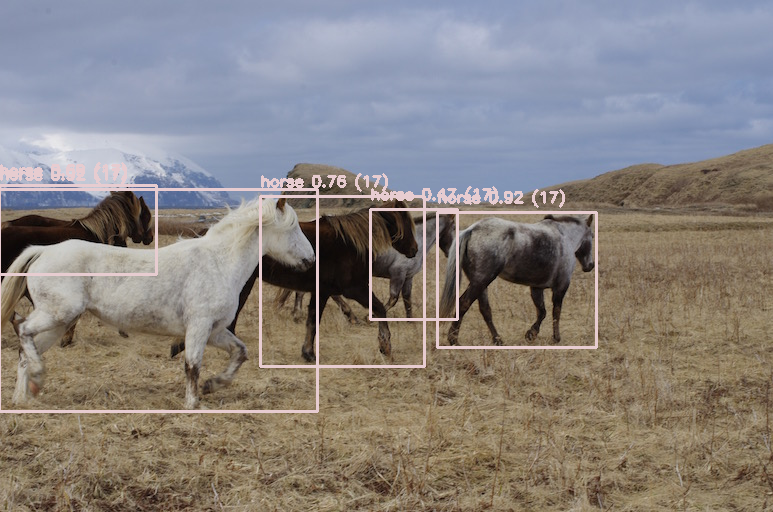

In [ ]:
image_path = '/content/yolov7/inference/images/horses.jpg'  #@param {type: "string"}
img = cv2.imread(image_path)
# cv2_imshow(img)
boxs,scores,cls_ids=detect(img)
detected_image=draw_box(img, boxs, scores, cls_ids)
cv2_imshow(detected_image)

In [ ]:
upload = False #@param {type:"boolean"}
from google.colab import files
if upload:
  uploaded = files.upload()
  image_upload=[]
  for fn in uploaded.keys():
    image_upload.append(fn)
  img = cv2.imread(image_upload[-1])
  boxs,scores,cls_ids=detect(img)
  detected_image=draw_box(img, boxs, scores, cls_ids)
  cv2_imshow(detected_image)



In [ ]:
# @title ##**js to image** { display-mode: "form" }

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# @title ##**video stream** { display-mode: "form" }

# JavaScript to properly create our live video stream using our webcam as input
def video_stream_mirror():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      video.style.transform = 'scaleX(-1)'; // mirror frame
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      // video.style.transform = 'scaleX(-1)'; // mirror frame
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
import time
from IPython.display import display as d
from IPython.display import Audio
from IPython.display import clear_output
def generate_voice(text,lang,voice_path):
  tts = gTTS(text,lang=lang, slow=False,tld='ca')
  tts.save(voice_path)
voice_path='/content/human.mp3'
generate_voice('Human detected','en',voice_path)
def alert(voice_path):
    d(Audio(voice_path, autoplay=True))


In [ ]:
# @title model configure { run: "auto" }
mirro_video = True #@param {type:"boolean"}
only_person = True #@param {type:"boolean"}
play_alarm = False #@param {type:"boolean"}
# start streaming video from webcam
if mirro_video:
  video_stream_mirror()
else:
  video_stream()
# label for video
label_html = 'Capturing...'

# initialize bounding box to empty
bbox = ''

count = 0
person_alarm_played = False
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    if mirro_video:
      frame=cv2.flip(frame,1)
    #object detection
    boxs,scores,cls_ids=detect(frame)
    #only extract humans
    if only_person:
      boxs,scores,cls_ids=get_person (boxs,scores,cls_ids)
      if 0 in cls_ids:
        #play a alrm audio file 
        if play_alarm:
          if not person_alarm_played:
            alert(voice_path)
            person_alarm_played = True
      else:
        person_alarm_played = False
        
      
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # loop through detections and draw them on transparent overlay image
    for i, box in enumerate(boxs):
        # color = (255, 255, 255)
        color = colors[names[cls_ids[i]]]
        score = scores[i]
        # label = f"person {score:.2f} ({cls_ids[i]})"
        label = f"{names[cls_ids[i]]} {score:.2f} ({cls_ids[i]})"

        x1, y1, x2, y2 = box
        bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), color, 2)
        bbox_array = cv2.putText(bbox_array, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes



In [ ]:
!pip install mediapipe

In [ ]:
import mediapipe as mp
class FaceDetector():
    def __init__(self, minDetectionCon=0.5):
        self.minDetectionCon = minDetectionCon
        self.mpDraw = mp.solutions.drawing_utils
        self.mpFaceDetection = mp.solutions.face_detection
        self.faceDetection = self.mpFaceDetection.FaceDetection(self.minDetectionCon, model_selection=1)
    def findFace(self, img):
        self.imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.faceDetection.process(self.imgRGB)
        faces = []
        cropped_faces = []
        if self.results.detections:
            for detection in self.results.detections:
                box = detection.location_data.relative_bounding_box
                ih, iw, ic = img.shape
                x1 = int(box.xmin * img.shape[1])
                y1 = int(box.ymin * img.shape[0])
                x2 = int((box.xmin + box.width) * iw)
                y2 = int((box.ymin + box.height) * ih)
                faces.append([x1, y1, x2, y2])
                # Crop face from the image
                face_image = img[y1:y2, x1:x2]
                # face_image = img[y1-90:y2+90, x1-90:x2+90]
                #resize face to train facenet model
                resized_image = cv2.resize(face_image, (160, 160))
                # resized_image = face_image
                # cv2.imshow("Cropped Face", resized_image)

                # Append the cropped face to the list
                cropped_faces.append(resized_image)
        return img, faces,cropped_faces

In [ ]:
!wget https://www.traveloffpath.com/wp-content/uploads/2021/03/Crowd-of-people-some-in-masks-and-some-not.jpg

--2023-03-24 06:48:27--  https://www.traveloffpath.com/wp-content/uploads/2021/03/Crowd-of-people-some-in-masks-and-some-not.jpg
Resolving www.traveloffpath.com (www.traveloffpath.com)... 172.67.176.219, 104.21.96.105, 2606:4700:3036::ac43:b0db, ...
Connecting to www.traveloffpath.com (www.traveloffpath.com)|172.67.176.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262744 (257K) [image/jpeg]
Saving to: ‘Crowd-of-people-some-in-masks-and-some-not.jpg’

Crowd-of-people-som 100%[===================>] 256.59K  1.17MB/s    in 0.2s    

2023-03-24 06:48:29 (1.17 MB/s) - ‘Crowd-of-people-some-in-masks-and-some-not.jpg’ saved [262744/262744]



In [ ]:
import csv
import os 
if not os.path.exists("/content/database.csv"):
  with open("/content/database.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["face_data"])
import uuid
def get_name():
  image_name = str(uuid.uuid4())[:10] + ".jpg"
  return image_name


In [ ]:
import shutil
try:
  shutil.rmtree("/content/dataset")
except:
  pass
!mkdir /content/dataset


In [ ]:
import shutil
try:
  shutil.rmtree("/content/face_dataset")
except:
  pass
!mkdir /content/face_dataset


In [ ]:
import torch
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
# Initialize face detector and resnet models
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
def facial_data(img):
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_name=get_name()
  save_path=f"/content/face_dataset/{img_name}"
  img_cropped = mtcnn(img_rgb ,save_path=save_path)
  img_cropped = img_cropped.to(device)
  img_embedding = resnet(img_cropped.unsqueeze(0))
  embedding_np = img_embedding.detach().cpu().numpy()
  embedding_list = embedding_np.tolist()[0]
  return embedding_list

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
import csv
def save_image(img,boxs,scores,cls_ids,extact_information=False):
  yolo_bodies=[]
  for i in boxs:
    x1,y1,x2,y2=i
    body_image = img[y1:y2, x1:x2]
    yolo_bodies.append(body_image)
  cv2.imwrite(f"/content/dataset/{get_name()}",img)
  if extact_information:
    for i,body in enumerate(yolo_bodies): 
      if scores[i]>0.40:
        try:
          embedding_list=facial_data(body)
          # print(embedding_list)
          # cv2_imshow(body)
          with open('/content/database.csv', mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([embedding_list])
        except:
              pass

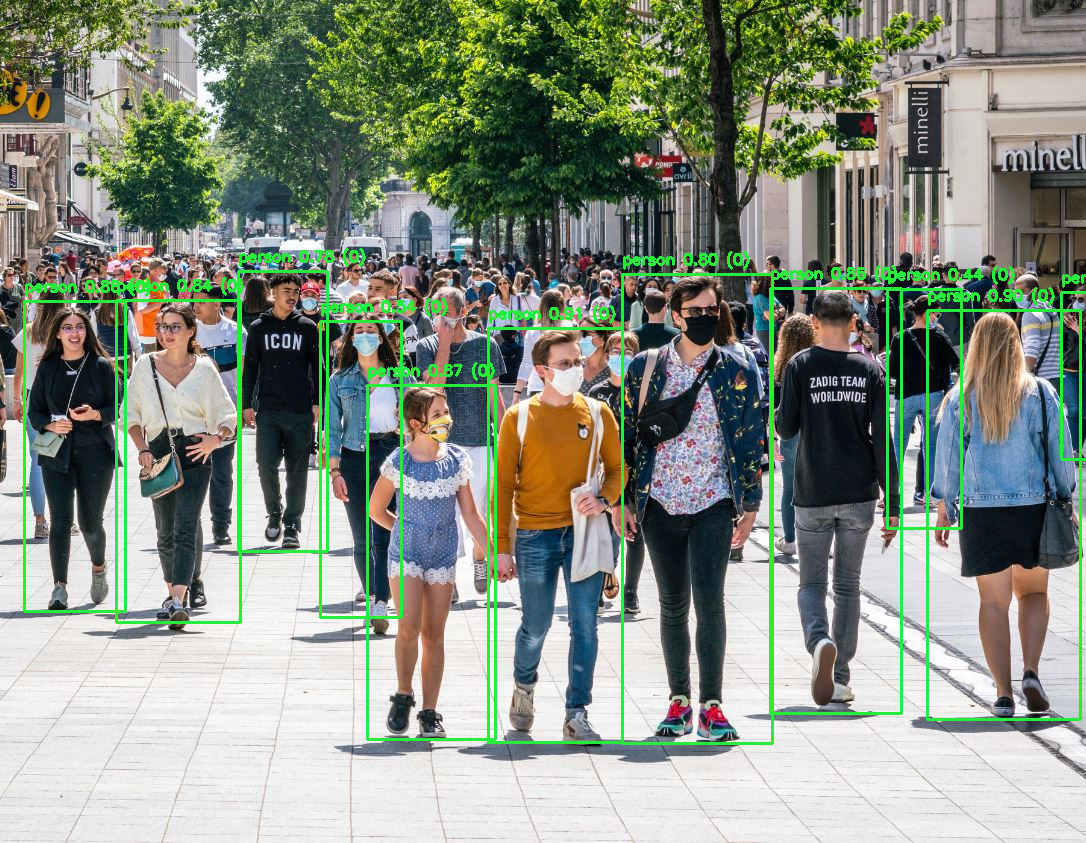

In [ ]:
image_path = '/content/yolov7/people.jpg'  #@param {type: "string"}
img = cv2.imread(image_path)
raw_img=img.copy()
# cv2_imshow(img)
boxs,scores,cls_ids=detect(img)
boxs,scores,cls_ids=get_person (boxs,scores,cls_ids)
detected_image=draw_box(img, boxs, scores, cls_ids)
cv2_imshow(detected_image)

In [ ]:
import csv
def save_image(img,boxs,scores,cls_ids,extact_information=False):
  yolo_bodies=[]
  for i in boxs:
    body_overlay = np.zeros_like(img)
    x1,y1,x2,y2=i
    body_image = img[y1:y2, x1:x2]
    body_overlay[y1:y2, x1:x2] = body_image
    cv2_imshow(body_overlay)


In [ ]:
save_image(raw_img,boxs,scores,cls_ids,extact_information=False)

In [ ]:
# @title model configure { run: "auto" }
mirro_video = True #@param {type:"boolean"}
only_person = True #@param {type:"boolean"}
save_data= True #@param {type:"boolean"}
extact_information= False #@param {type:"boolean"}

# play_alarm = False #@param {type:"boolean"}
# start streaming video from webcam
if mirro_video:
  video_stream_mirror()
else:
  video_stream()
# label for video
label_html = 'Capturing...'

# initialize bounding box to empty
bbox = ''

count = 0
person_alarm_played = False
save_facial_data=False
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    if mirro_video:
      frame=cv2.flip(frame,1)
    #object detection
    boxs,scores,cls_ids=detect(frame)
    #only extract humans
    if only_person:
      boxs,scores,cls_ids=get_person (boxs,scores,cls_ids)
      if 0 in cls_ids:
        if save_data:
          if not save_facial_data:
            save_image(frame,boxs,scores,cls_ids,extact_information)
            save_facial_data=True
        else:
          pass
        # if play_alarm:
        #   if not person_alarm_played:
        #     alert(voice_path)
        #     person_alarm_played = True
      else:
        # person_alarm_played = False
        save_facial_data=False
        
      
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # loop through detections and draw them on transparent overlay image
    for i, box in enumerate(boxs):
        # color = (255, 255, 255)
        color = colors[names[cls_ids[i]]]
        score = scores[i]
        # label = f"person {score:.2f} ({cls_ids[i]})"
        label = f"{names[cls_ids[i]]} {score:.2f} ({cls_ids[i]})"

        x1, y1, x2, y2 = box
        bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), color, 2)
        bbox_array = cv2.putText(bbox_array, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes



In [ ]:
import asyncio

async def save_image_async(img, boxs, scores, cls_ids):
    yolo_bodies = []
    for i in boxs:
        x1, y1, x2, y2 = i
        body_image = img[y1:y2, x1:x2]
        yolo_bodies.append(body_image)
    
    for body in yolo_bodies:
        try:
            _, faces, cropped_faces = detector.findFace(body)
            for i in cropped_faces:
                try:
                    embedding = extract_embedding(i)
                    with open('/content/database.csv', mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow([embedding])
                    cv2.imwrite(f"/content/face_dataset/{get_name()}", i)
                    # cv2_imshow(i)
                except:
                    pass 
        except:
            pass 

async def main():
    tasks = []
    for i in range(10):
        task = asyncio.create_task(save_image_async(img, boxs, scores, cls_ids))
        tasks.append(task)
    await asyncio.gather(*tasks)

# Call the main function
await main()


In [ ]:
!wget https://github.com/foamliu/MobileFaceNet/releases/download/v1.0/mobilefacenet_scripted.pt

In [ ]:
/content/yolov7/mobilefacenet_scripted.pt

In [ ]:
import torch
import torchvision.transforms as transforms
import cv2

# Load the MobileFaceNet model
face_model = torch.load("mobilefacenet.pt")

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
face_model.to(device)

# Set the model to evaluation mode
face_model.eval()

# Define the input image transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((112, 112)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

FileNotFoundError: ignored

In [ ]:


# Load an example image of a face
img = cv2.imread("/content/test.jpg")

# Apply the input image transform
img_tensor = transform(img).unsqueeze(0)

# Move the input tensor to the GPU
img_tensor = img_tensor.to(device)

# Pass the image tensor through the model
output = model(img_tensor)

# The output is a tensor of shape (1, 512), where each element represents a feature of the face
# You can use these features for face recognition by comparing them to features of other faces

# Print the output tensor
print(output)


In [ ]:
import torch
import numpy as np
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1

# Initialize face detector and resnet models
device = torch.device('cpu')
mtcnn = MTCNN(device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def facial_data(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_name=get_name()
    save_path=f"/content/face_dataset/{img_name}"
    img_cropped = mtcnn(img_rgb, save_path=save_path)
    img_cropped = img_cropped.to(device)
    img_embedding = resnet(img_cropped.unsqueeze(0))
    embedding_np = img_embedding.detach().cpu().numpy()
    embedding_list = embedding_np.tolist()[0]
    return embedding_list
